In [26]:
# the bare minimum
import matplotlib.pyplot as plt
import geopandas as gpd

# more advanced
import pyogrio as ogr
from sklearn.cluster import KMeans
from lonboard import Map, PolygonLayer
from lonboard.colormap import apply_categorical_cmap, apply_continuous_cmap
from palettable.colorbrewer.sequential import PuRd_9
from matplotlib.colors import LogNorm

import pydeck as pdk

import pandas as pd
from shapely.geometry import Point

import folium
import numpy as np  # Make sure to import NumPy


In [2]:
# Path to the SHP file
shp_path = "C:/Users/fauxi/OneDrive/Documents/GitHub/cdp-mapping-systems/Tutorials/Neighborhood Names GIS/geo_export_fbb31ac1-a663-4410-b3b9-35824d262743.shx"

# Read the SHP file
gdf = gpd.read_file(shp_path)

print("GeoDataFrame columns:", gdf.columns)

GeoDataFrame columns: Index(['annoangle', 'annoline1', 'annoline2', 'annoline3', 'borough', 'name',
       'objectid', 'stacked', 'geometry'],
      dtype='object')


In [3]:
gdf.columns

Index(['annoangle', 'annoline1', 'annoline2', 'annoline3', 'borough', 'name',
       'objectid', 'stacked', 'geometry'],
      dtype='object')

In [4]:
# Filter the GeoDataFrame to include only Manhattan neighborhoods
manhattan_gdf = gdf[gdf['borough'] == 'Manhattan']  # Replace 'borough' with the actual column name for boroughs in the SHP file

In [5]:
# Path to the CSV file
csv_path = "../Tutorials/medianAskingRent_All.csv"

In [6]:
# Read the CSV file
df = pd.read_csv(csv_path)

print("DataFrame columns:", df.columns)

DataFrame columns: Index(['Name', 'Borough', 'askingRent'], dtype='object')


In [7]:
# Display the first few rows to understand the structure
print(df.head())

                  Name    Borough  askingRent
0         All Downtown  Manhattan      4995.0
1          All Midtown  Manhattan      4595.0
2  All Upper East Side  Manhattan      3900.0
3  All Upper Manhattan  Manhattan      3000.0
4  All Upper West Side  Manhattan      4400.0


In [8]:
# Filter the DataFrame to include only Manhattan neighborhoods
manhattan_df = df[df['Borough'] == 'Manhattan']  # Replace 'borough' with the actual column name for boroughs in the CSV file

In [9]:
# Merge the filtered GeoDataFrame with the filtered DataFrame on the neighborhood name
merged_gdf = manhattan_gdf.merge(manhattan_df, left_on='name', right_on='Name')

In [10]:
# Now merged_gdf is a GeoDataFrame containing both the neighborhood geometries and the median asking rents for Manhattan neighborhoods
print(merged_gdf.head())

   annoangle   annoline1 annoline2 annoline3    borough                name  \
0        0.0      Marble      Hill      None  Manhattan         Marble Hill   
1        0.0   Chinatown      None      None  Manhattan           Chinatown   
2        0.0  Washington   Heights      None  Manhattan  Washington Heights   
3        0.0      Inwood      None      None  Manhattan              Inwood   
4        0.0    Hamilton   Heights      None  Manhattan    Hamilton Heights   

   objectid  stacked                    geometry                Name  \
0       7.0      2.0  POINT (-73.91066 40.87655)         Marble Hill   
1     103.0      1.0  POINT (-73.99428 40.71562)           Chinatown   
2     104.0      2.0  POINT (-73.93690 40.85190)  Washington Heights   
3     105.0      1.0  POINT (-73.92121 40.86768)              Inwood   
4     106.0      2.0  POINT (-73.94969 40.82360)    Hamilton Heights   

     Borough  askingRent  
0  Manhattan         NaN  
1  Manhattan      3248.0  
2  Manhatta

In [11]:
# Assuming your merged DataFrame is called 'merged_gdf'
# Sort the data for better visualization, if needed
sorted_gdf = merged_gdf.sort_values(by='askingRent', ascending=False)

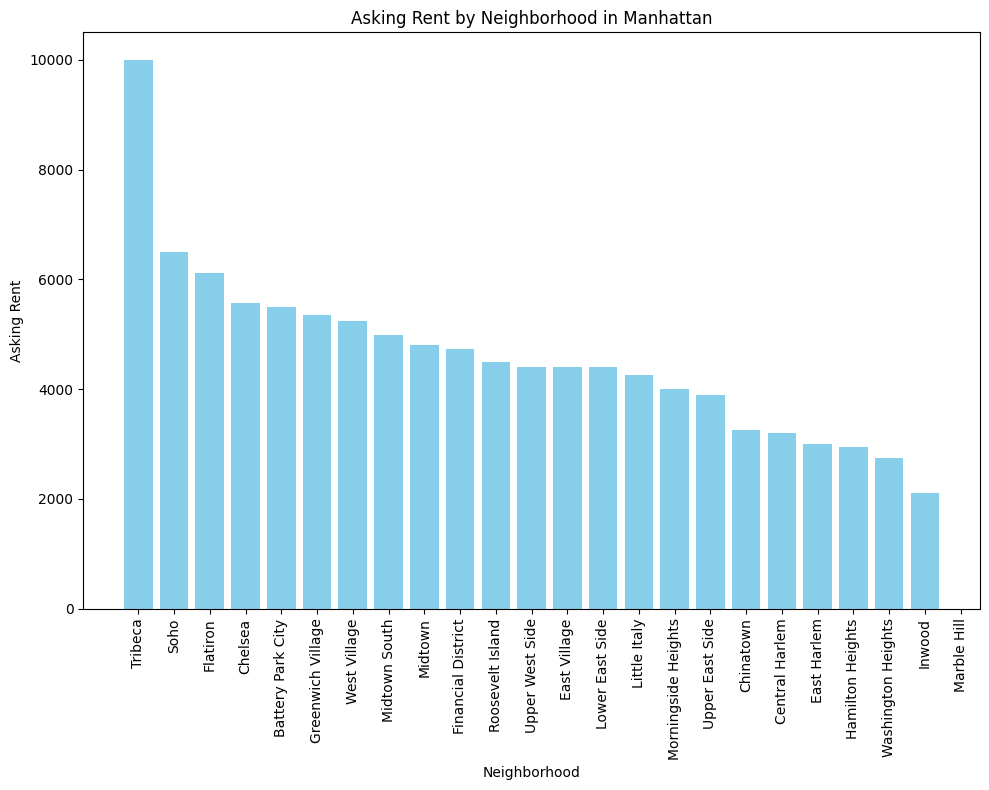

In [12]:
# Plotting
plt.figure(figsize=(10, 8))  # Set the figure size (width, height) in inches
plt.bar(sorted_gdf['Name'], sorted_gdf['askingRent'], color='skyblue')  # Create a bar chart
plt.xlabel('Neighborhood')  # Label on the x-axis
plt.ylabel('Asking Rent')  # Label on the y-axis
plt.title('Asking Rent by Neighborhood in Manhattan')  # Title of the graph
plt.xticks(rotation=90)  # Rotate the x-axis labels for better visibility
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.show()  # Display the plot

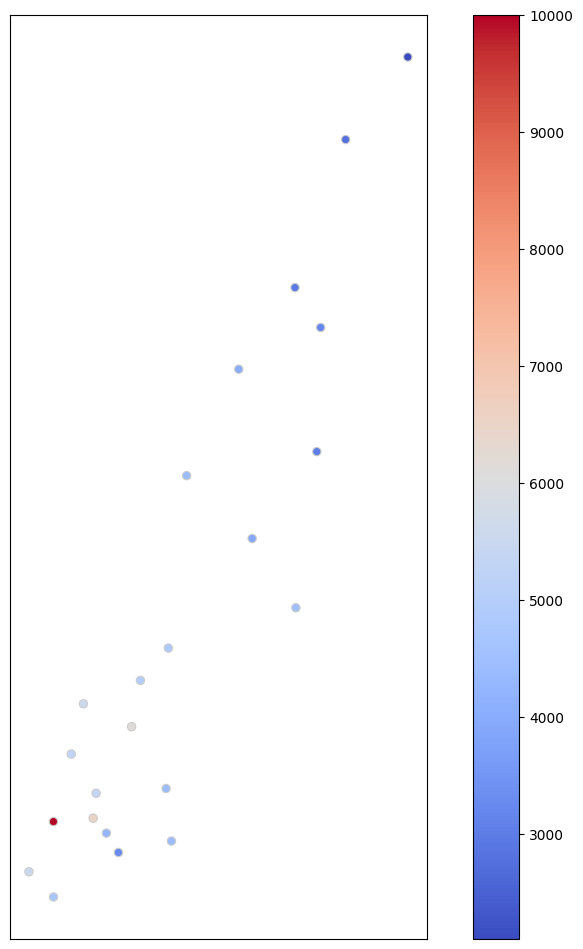

In [15]:
# Assuming your merged GeoDataFrame is called 'merged_gdf'
fig, ax = plt.subplots(1, 1, figsize=(12, 12))  # Create figure and axes objects

# Plotting the GeoDataFrame
merged_gdf.plot(column='askingRent', cmap='coolwarm', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
# The 'coolwarm' colormap ranges from blue (low values) to red (high values)

# Remove the x and y axis for a cleaner look
ax.set_xticks([])
ax.set_yticks([])

# Show the figure
plt.show()


In [18]:
# Assuming 'merged_gdf' is already loaded and merged correctly

# Handling missing values
merged_gdf['askingRent'] = merged_gdf['askingRent'].fillna(merged_gdf['askingRent'].median())

# Define a function to choose colors based on asking rent
def color_producer(val):
    if val is None:
        return 'gray'  # or another neutral color to indicate missing data
    elif val < merged_gdf['askingRent'].quantile(0.33):
        return 'blue'
    elif val < merged_gdf['askingRent'].quantile(0.67):
        return 'green'
    else:
        return 'red'

# Create the map
x_map = merged_gdf.geometry.centroid.x.mean()
y_map = merged_gdf.geometry.centroid.y.mean()
m = folium.Map(location=[y_map, x_map], zoom_start=12, tiles='CartoDB positron')

# Add the GeoDataFrame to the Folium map
folium.GeoJson(
    merged_gdf,
    style_function=lambda feature: {
        'fillColor': color_producer(feature['properties']['askingRent']),
        'color': 'black',
        'weight': 0.5,
        'fillOpacity': 0.7,
    },
    tooltip=folium.GeoJsonTooltip(
        fields=['Name', 'askingRent'],
        aliases=['Neighborhood:', 'Asking Rent:'],
        localize=True
    )
).add_to(m)

# Display the map
m.save('Manhattan_rent_map.html')
m  # Display inline if in a Jupyter notebook


C:\Users\fauxi\AppData\Local\Temp\ipykernel_20744\3658629442.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  x_map = merged_gdf.geometry.centroid.x.mean()
C:\Users\fauxi\AppData\Local\Temp\ipykernel_20744\3658629442.py:19: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  y_map = merged_gdf.geometry.centroid.y.mean()


In [20]:
import folium
import geopandas as gpd
import branca.colormap as cm

# Assuming 'merged_gdf' is already loaded and merged correctly
# Handling missing values
merged_gdf['askingRent'] = merged_gdf['askingRent'].fillna(merged_gdf['askingRent'].median())

# Create the map
x_map = merged_gdf.geometry.centroid.x.mean()
y_map = merged_gdf.geometry.centroid.y.mean()
m = folium.Map(location=[y_map, x_map], zoom_start=12, tiles='CartoDB positron')

# Define a color scale
min_rent = merged_gdf['askingRent'].min()
max_rent = merged_gdf['askingRent'].max()
colormap = cm.linear.YlOrRd_09.scale(min_rent, max_rent)
colormap.caption = 'Asking Rent'

# Function to assign color based on asking rent
def style_function(feature):
    rent = feature['properties']['askingRent']
    return {
        'fillColor': colormap(rent),
        'color': 'black',
        'weight': 0.5,
        'fillOpacity': 0.7
    }

# Add the GeoDataFrame as a GeoJson layer with styled color
folium.GeoJson(
    merged_gdf.to_json(),
    style_function=style_function,
    tooltip=folium.GeoJsonTooltip(
        fields=['Name', 'askingRent'],
        aliases=['Neighborhood:', 'Asking Rent:']
    )
).add_to(m)

# Add the colormap to the map
colormap.add_to(m)

# Display the map
m.save('Manhattan_rent_map.html')
m  # Display inline if in a Jupyter notebook


C:\Users\fauxi\AppData\Local\Temp\ipykernel_20744\3782791248.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  x_map = merged_gdf.geometry.centroid.x.mean()
C:\Users\fauxi\AppData\Local\Temp\ipykernel_20744\3782791248.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  y_map = merged_gdf.geometry.centroid.y.mean()


In [23]:
import folium
import branca.colormap as cm

# Assuming 'merged_gdf' is already loaded and merged correctly
# Handling missing values
merged_gdf['askingRent'] = merged_gdf['askingRent'].fillna(merged_gdf['askingRent'].median())

# Create the map
x_map = merged_gdf.geometry.centroid.x.mean()
y_map = merged_gdf.geometry.centroid.y.mean()
m = folium.Map(location=[y_map, x_map], zoom_start=12, tiles='CartoDB positron')

# Define a color scale
min_rent = merged_gdf['askingRent'].min()
max_rent = merged_gdf['askingRent'].max()
colormap = cm.linear.YlOrRd_09.scale(min_rent, max_rent)
colormap.caption = 'Asking Rent'

# Function to assign color based on asking rent
def get_color(rent):
    return colormap(rent)

# Add colored circle markers
for idx, row in merged_gdf.iterrows():
    folium.CircleMarker(
        location=[row.geometry.centroid.y, row.geometry.centroid.x],
        radius=15, # Size of the circle marker
        fill=True,
        color=get_color(row['askingRent']),
        fill_color=get_color(row['askingRent']),
        fill_opacity=0.7,
        tooltip=f"Neighborhood: {row['Name']}<br>Asking Rent: {row['askingRent']}"
    ).add_to(m)

# Add the colormap to the map
colormap.add_to(m)

# Display the map
m.save('Manhattan_rent_map.html')
m  # Display inline if in a Jupyter notebook


C:\Users\fauxi\AppData\Local\Temp\ipykernel_20744\3654875881.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  x_map = merged_gdf.geometry.centroid.x.mean()
C:\Users\fauxi\AppData\Local\Temp\ipykernel_20744\3654875881.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  y_map = merged_gdf.geometry.centroid.y.mean()


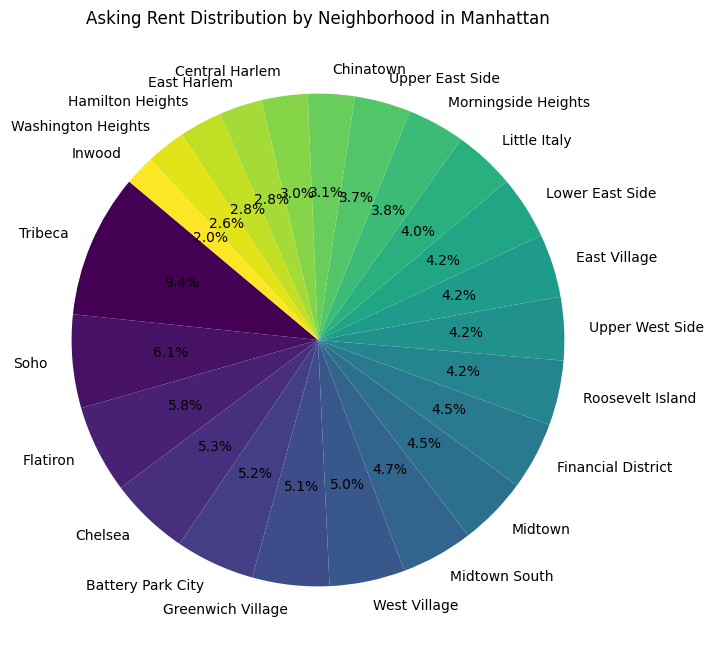

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'sorted_gdf' is your DataFrame and it's sorted by 'askingRent'
# Remove rows where 'askingRent' is NaN
sorted_gdf = sorted_gdf.dropna(subset=['askingRent'])

# Ensure there are still rows left in the DataFrame
if not sorted_gdf.empty:
    colors = plt.cm.viridis(np.linspace(0, 1, len(sorted_gdf)))  # Generate a color map

    # Create a pie chart
    plt.figure(figsize=(10, 8))
    plt.pie(sorted_gdf['askingRent'], labels=sorted_gdf['Name'], autopct='%1.1f%%', startangle=140, colors=colors)
    plt.title('Asking Rent Distribution by Neighborhood in Manhattan')
    plt.show()
else:
    print("No data available to plot.")


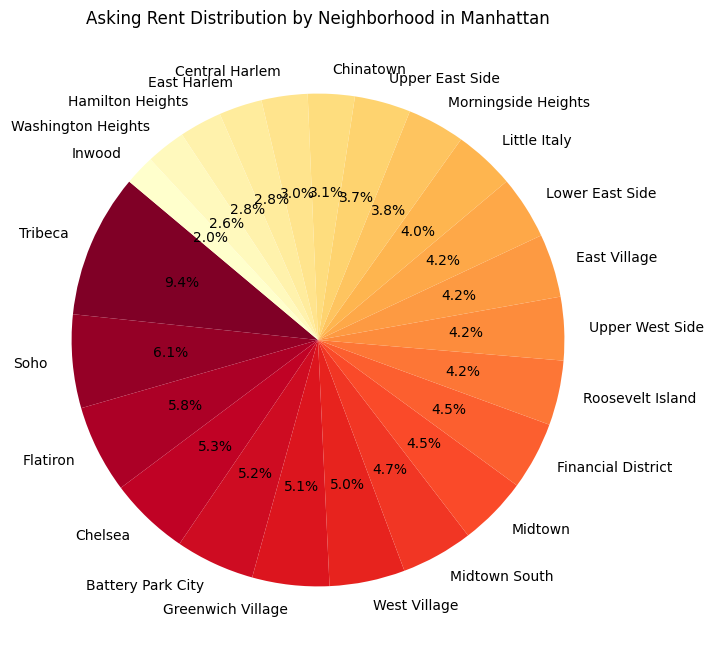

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'sorted_gdf' is your DataFrame and it's sorted by 'askingRent'
# Remove rows where 'askingRent' is NaN
sorted_gdf = sorted_gdf.dropna(subset=['askingRent'])

# Generate a reversed color map from Dark Red to Light Yellow
cmap = plt.get_cmap('YlOrRd')  # Get the Yellow-Orange-Red colormap
colors = cmap(np.linspace(1, 0, len(sorted_gdf)))  # Generate colors from this colormap, reversed

# Create a pie chart
plt.figure(figsize=(10, 8))
plt.pie(sorted_gdf['askingRent'], labels=sorted_gdf['Name'], autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Asking Rent Distribution by Neighborhood in Manhattan')
plt.show()


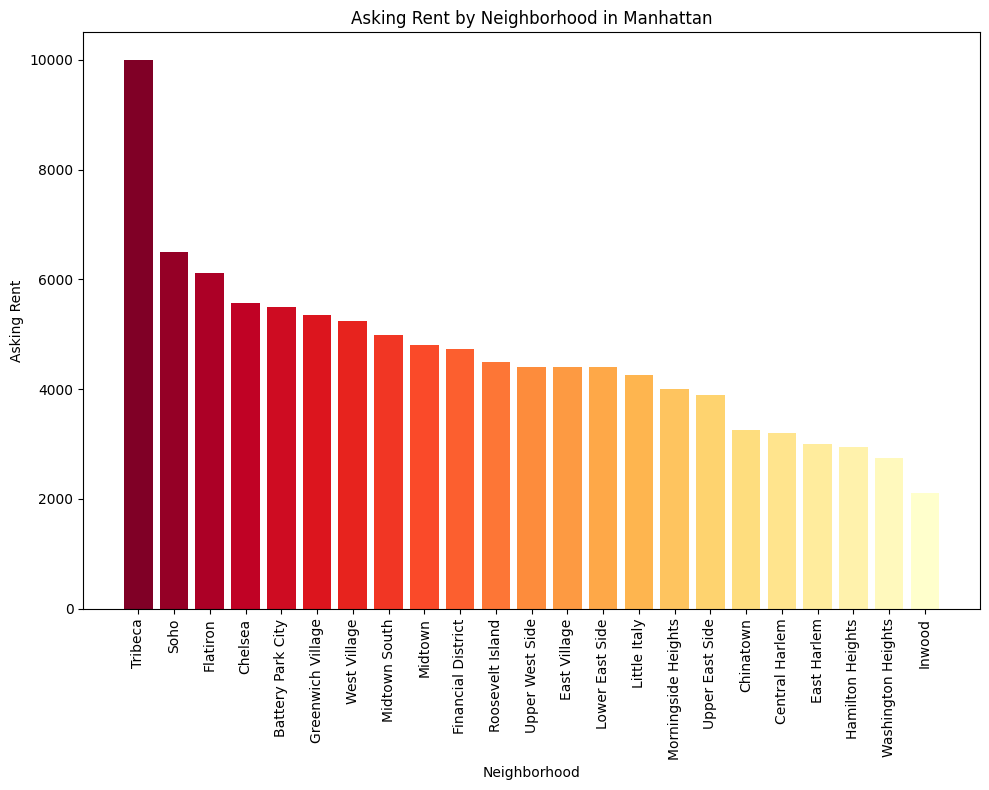

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'sorted_gdf' is your DataFrame and it's sorted by 'askingRent'
# Check and handle NaN values if necessary
sorted_gdf = sorted_gdf.dropna(subset=['askingRent'])

# Generate a reversed color map from Dark Red to Light Yellow
cmap = plt.get_cmap('YlOrRd')  # Get the Yellow-Orange-Red colormap
colors = cmap(np.linspace(1, 0, len(sorted_gdf)))  # Generate colors from this colormap, reversed

# Create a bar chart
plt.figure(figsize=(10, 8))
plt.bar(sorted_gdf['Name'], sorted_gdf['askingRent'], color=colors)  # Apply the color array to the bar colors
plt.xlabel('Neighborhood')  # Label on the x-axis
plt.ylabel('Asking Rent')  # Label on the y-axis
plt.title('Asking Rent by Neighborhood in Manhattan')  # Title of the graph
plt.xticks(rotation=90)  # Rotate the x-axis labels for better visibility
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.show()  # Display the plot
